# Project 7 - Notes for choosing hyperparameter for text input

**Author: Linh Nguyen**<br>

**StudentID: 23161711**<br>

**Date: Sep 2022**

## 1. Load data and import package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_project

Mounted at /content/drive
/content/drive/MyDrive/Capstone_project


In [ ]:
import numpy as np
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score

In [ ]:
! ls /content/drive/MyDrive/Capstone_project/raw

diagnosis.csv  icd9toicd10cmgem.csv  pyxis.csv	 vitalsign.csv
edstays.csv    medrecon.csv	     triage.csv


In [ ]:
triage = pd.read_csv('raw/triage.csv')

In [ ]:
edstays = pd.read_csv('raw/edstays.csv')
edstays['y_var_adm_text'] = edstays['disposition']
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [ ]:
triage_1 = pd.merge(edstays_admit[['subject_id', 'stay_id','y_var_adm_text']],triage,how = 'left',on=['subject_id', 'stay_id'])

In [ ]:
triage_1['y_var'] = 0
triage_1.loc[triage_1['y_var_adm_text'] == 'ADMITTED', 'y_var']  = 1

In [ ]:
triage_2 = triage_1[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [ ]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
209834,14913519,33280070,1,NaN
219040,15127661,39766508,1,NaN
230046,15376111,34216718,1,NaN
241580,15632852,37860864,0,NaN
307992,17192157,31192693,0,NaN
322362,17526143,30744048,1,NaN
356784,18321345,37024607,1,NaN
360935,18425846,33948058,1,NaN


In [ ]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

In [ ]:
triage_3

,subject_id,stay_id,y_var,chiefcomplaint,Unnamed: 0,key,fin_code_group,hadm_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,pre_icd_code
0,10000032,33258284,1,"abd pain , abdominal distention",0,10000032_33258284,"['K72', 'R18', '707', 'Z21']",22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,NaN
1,10000032,38112554,1,abdominal distention,1,10000032_38112554,"['R18', '707', 'K74', 'Z21']",22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"K72,R18,707,Z21"
2,10000032,35968195,1,"n v d , abd pain",4,10000032_35968195,"['K74', 'R10', 'Z21']",25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"R41,G93"
3,10000032,32952584,0,hypotension,2,10000032_32952584,"['I95', '707', 'Z21']",29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,HOME,"R18,707,K74,Z21"
4,10000032,39399961,1,"abdominal distention , abd pain , lethagic",3,10000032_39399961,"['R41', 'G93']",29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"I95,707,Z21"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,34149746,1,wound eval,428280,19999784_34149746,"['G97', 'G96', 'Y83', 'Y92']",25715748.0,2119-08-11 09:15:00,2119-08-11 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,R53
428280,19999784,35692999,1,l leg weakness,428278,19999784_35692999,['R53'],26194817.0,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,NaN
428281,19999828,32917002,1,"abd pain , wound eval",428282,19999828_32917002,"['E11', 'Z79']",25744818.0,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,K63
428282,19999828,30712109,1,"abd pain , wound eval",428281,19999828_30712109,['K63'],29734428.0,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,NaN


# 2. Text data overview

In [ ]:
def print_plot_length(df,x_var,y_var):
    def calculate_length(x):
        if type(x) == float:
            if x > 0:
                r = len(x.replace(',',' ').split())
            else: r = 0
        else:
            r = len(x.replace(',',' ').split())
        
        return(r)
    df['length'] = df[x_var].apply(calculate_length)
    positive_lengths = df[df[y_var]==1]['length']
    negative_lengths = df[df[y_var]==0]['length']
    plt.figure(figsize=(15,5))
    plt.title(x_var + ' length distribution')
    sns.distplot(negative_lengths, kde=False)
    sns.distplot(positive_lengths, kde=False)
    plt.legend(['home', 'admitted'])
    plt.xlabel('no of words')
    plt.ylabel('no of observations')
    plt.grid(False)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


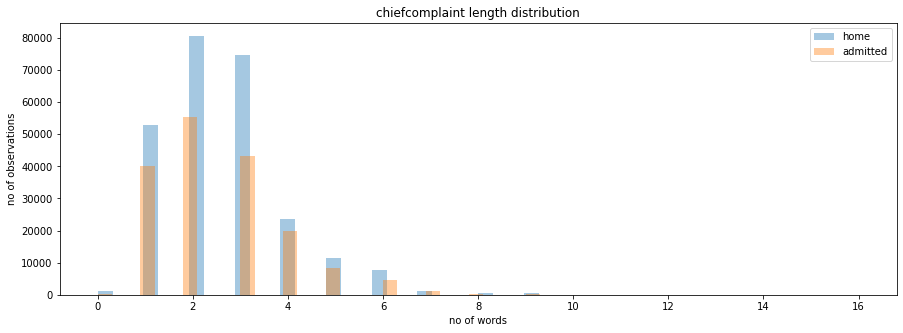

In [ ]:
print_plot_length(triage_3,'chiefcomplaint','y_var')

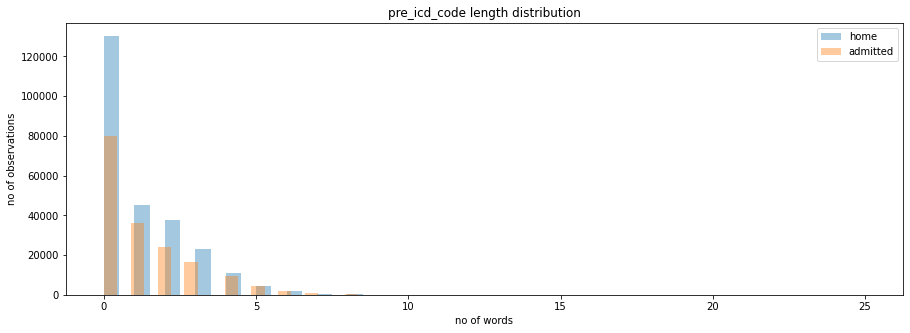

In [ ]:
print_plot_length(triage_3,'pre_icd_code','y_var')

In [ ]:
# 2. Split the dataset

In [ ]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create train index = 0.20 * random index to end
train_index = ind[int(len(triage_3) * 0.20):]

In [ ]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.pre_icd_code[train_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.pre_icd_code[test_index]

train_labels =  triage_3.y_var[train_index]
test_labels = triage_3.y_var[test_index]

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [ ]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'l']

In [ ]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 20,  0])

In [ ]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format('W2vec/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4441 words (178 misses)


In [ ]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [ ]:
his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [ ]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [ ]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [ ]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [ ]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 3.3 Concat 2 embedding

In [ ]:
#tf.concat([embedding_layer(x_train[0]),[embedding_layer_his(x_train[0])]],0)

# 4 BiGRU model using current data (chief complaint)

In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 62.6 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 147 kB 64.7 MB/s 
     |████████████████████████████████| 112 kB 68.0 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 


In [ ]:
RANDOM_SEED = 42
from sklearn.model_selection import KFold
import optuna

# 5-fold CV
kfolds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params




In [ ]:
# K-fold Cross Validation model evaluation


x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
y_train = np.array(train_labels)


def BiGRU(trial):
    units = trial.suggest_int("units", 100, 200)
    activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    optimizer = trial.suggest_categorical("optimizer", ['adam', 'rmsprop'])
    dropout_rate = trial.suggest_int("rate", 0.2, 0.5)
    col1 = keras.Input(shape=(5,))
    embedded_sequences = embedding_layer(col1)
    x = keras.layers.Bidirectional(keras.layers.GRU(units, return_sequences=True, activation = activation))(embedded_sequences)
    x = keras.layers.Bidirectional(keras.layers.GRU(units, activation = activation))(x)
    x = keras.layers.Dense(units/2,activation = activation)(x)
    x = keras.layers.Dropout(rate = dropout_rate)(x)
    preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
    model = keras.Model(col1, preds)
    weights = [1-(sum(train_labels)/len(train_labels)),sum(train_labels)/len(train_labels)]

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, loss_weights = weights, metrics = "accuracy")
    acc_per_fold = []
    loss_per_fold = []
    early = EarlyStopping(monitor='loss', patience=5)
    for train, test in kfolds.split(x_train, y_train):
        model.fit(x_train[train], y_train[train],batch_size=256, epochs=100, callbacks=[early])

  # Generate generalization metrics
        scores = model.evaluate(x_train[test], y_train[test])
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
    
    return np.mean(acc_per_fold)

GRU_params = tune(BiGRU)

[I 2022-09-04 10:43:42,090] A new study created in memory with name: no-name-be841d49-b54e-4c7b-881e-384a8aa1ba79


Epoch 1/100
1071/1071 [==============================] - 69s 56ms/step - loss: 0.3219 - accuracy: 0.7263
Epoch 2/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3152 - accuracy: 0.7333
Epoch 3/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3131 - accuracy: 0.7350
Epoch 4/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3115 - accuracy: 0.7361
Epoch 5/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3103 - accuracy: 0.7375
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3090 - accuracy: 0.7390
Epoch 7/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3076 - accuracy: 0.7405
Epoch 8/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3062 - accuracy: 0.7413
Epoch 9/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3047 - accuracy: 0.7432
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 12:58:20,217] Trial 0 finished with value: 74.6958839893341 and parameters: {'units': 174, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 74.6958839893341.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3220 - accuracy: 0.7253
Epoch 2/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3151 - accuracy: 0.7332
Epoch 3/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3132 - accuracy: 0.7353
Epoch 4/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3117 - accuracy: 0.7367
Epoch 5/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3103 - accuracy: 0.7377
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3091 - accuracy: 0.7387
Epoch 7/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3079 - accuracy: 0.7399
Epoch 8/100
1071/1071 [==============================] - 56s 53ms/step - loss: 0.3065 - accuracy: 0.7413
Epoch 9/100
1071/1071 [==============================] - 56s 52ms/step - loss: 0.3050 - accuracy: 0.7428
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 15:48:17,265] Trial 1 finished with value: 74.7063934803009 and parameters: {'units': 147, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 21s 11ms/step - loss: 0.3276 - accuracy: 0.7209
Epoch 2/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3174 - accuracy: 0.7303
Epoch 3/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3146 - accuracy: 0.7336
Epoch 4/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3128 - accuracy: 0.7355
Epoch 5/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3112 - accuracy: 0.7362
Epoch 6/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3096 - accuracy: 0.7381
Epoch 7/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3079 - accuracy: 0.7394
Epoch 8/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3060 - accuracy: 0.7422
Epoch 9/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3043 - accuracy: 0.7438
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 16:33:59,786] Trial 2 finished with value: 74.06021118164062 and parameters: {'units': 186, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 65s 55ms/step - loss: 0.3232 - accuracy: 0.7246
Epoch 2/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3157 - accuracy: 0.7325
Epoch 3/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3140 - accuracy: 0.7345
Epoch 4/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3127 - accuracy: 0.7360
Epoch 5/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3124 - accuracy: 0.7369
Epoch 6/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3123 - accuracy: 0.7372
Epoch 7/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3123 - accuracy: 0.7380
Epoch 8/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3435 - accuracy: 0.7376
Epoch 9/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3401 - accuracy: 0.7373
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 17:15:28,962] Trial 3 finished with value: 73.19366455078125 and parameters: {'units': 107, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 16s 9ms/step - loss: 0.3247 - accuracy: 0.7234
Epoch 2/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3174 - accuracy: 0.7301
Epoch 3/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3151 - accuracy: 0.7332
Epoch 4/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3136 - accuracy: 0.7339
Epoch 5/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3123 - accuracy: 0.7355
Epoch 6/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3111 - accuracy: 0.7364
Epoch 7/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3097 - accuracy: 0.7373
Epoch 8/100
1071/1071 [==============================] - 9s 9ms/step - loss: 0.3084 - accuracy: 0.7392
Epoch 9/100
1071/1071 [==============================] - 10s 9ms/step - loss: 0.3069 - accuracy: 0.7405
Epoch 10/100
1071/1071 [==============================] - 10s 9ms/step 

[I 2022-09-04 17:52:03,582] Trial 4 finished with value: 74.32171940803528 and parameters: {'units': 122, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 18s 10ms/step - loss: 0.3269 - accuracy: 0.7198
Epoch 2/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3173 - accuracy: 0.7308
Epoch 3/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3146 - accuracy: 0.7329
Epoch 4/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3128 - accuracy: 0.7350
Epoch 5/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3114 - accuracy: 0.7368
Epoch 6/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3098 - accuracy: 0.7385
Epoch 7/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3084 - accuracy: 0.7391
Epoch 8/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3068 - accuracy: 0.7410
Epoch 9/100
1071/1071 [==============================] - 11s 10ms/step - loss: 0.3053 - accuracy: 0.7429
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 18:42:38,379] Trial 5 finished with value: 73.95718097686768 and parameters: {'units': 120, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 18s 11ms/step - loss: 0.3281 - accuracy: 0.7206
Epoch 2/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3173 - accuracy: 0.7309
Epoch 3/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3147 - accuracy: 0.7335
Epoch 4/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3127 - accuracy: 0.7350
Epoch 5/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3111 - accuracy: 0.7368
Epoch 6/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3095 - accuracy: 0.7389
Epoch 7/100
1071/1071 [==============================] - 12s 11ms/step - loss: 0.3079 - accuracy: 0.7406
Epoch 8/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3060 - accuracy: 0.7424
Epoch 9/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3041 - accuracy: 0.7438
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 19:20:07,518] Trial 6 finished with value: 74.14017915725708 and parameters: {'units': 198, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 18s 11ms/step - loss: 0.3276 - accuracy: 0.7203
Epoch 2/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3174 - accuracy: 0.7297
Epoch 3/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3146 - accuracy: 0.7334
Epoch 4/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3126 - accuracy: 0.7351
Epoch 5/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3111 - accuracy: 0.7365
Epoch 6/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3094 - accuracy: 0.7386
Epoch 7/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3076 - accuracy: 0.7396
Epoch 8/100
1071/1071 [==============================] - 12s 11ms/step - loss: 0.3059 - accuracy: 0.7422
Epoch 9/100
1071/1071 [==============================] - 11s 11ms/step - loss: 0.3039 - accuracy: 0.7435
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-04 20:00:35,199] Trial 7 finished with value: 74.02139186859131 and parameters: {'units': 183, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 64s 54ms/step - loss: 0.3233 - accuracy: 0.7238
Epoch 2/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3157 - accuracy: 0.7327
Epoch 3/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3139 - accuracy: 0.7344
Epoch 4/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3130 - accuracy: 0.7360
Epoch 5/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3128 - accuracy: 0.7365
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3144 - accuracy: 0.7368
Epoch 7/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3213 - accuracy: 0.7379
Epoch 8/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3557 - accuracy: 0.7379
Epoch 9/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3325 - accuracy: 0.7373
Epoch 10/100
2142/2142 [==============================]

[I 2022-09-04 20:47:38,247] Trial 8 finished with value: 73.09910655021667 and parameters: {'units': 132, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 64s 55ms/step - loss: 0.3231 - accuracy: 0.7246
Epoch 2/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3156 - accuracy: 0.7325
Epoch 3/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3139 - accuracy: 0.7345
Epoch 4/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3132 - accuracy: 0.7356
Epoch 5/100
1071/1071 [==============================] - 58s 55ms/step - loss: 0.3126 - accuracy: 0.7365
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3132 - accuracy: 0.7374
Epoch 7/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3170 - accuracy: 0.7370
Epoch 8/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3224 - accuracy: 0.7374
Epoch 9/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3414 - accuracy: 0.7380
Epoch 10/100
2142/2142 [==============================]

[I 2022-09-04 21:27:07,441] Trial 9 finished with value: 72.9601788520813 and parameters: {'units': 104, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3219 - accuracy: 0.7260
Epoch 2/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3151 - accuracy: 0.7331
Epoch 3/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3133 - accuracy: 0.7347
Epoch 4/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3119 - accuracy: 0.7365
Epoch 5/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3106 - accuracy: 0.7375
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3093 - accuracy: 0.7383
Epoch 7/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3081 - accuracy: 0.7397
Epoch 8/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3066 - accuracy: 0.7409
Epoch 9/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3052 - accuracy: 0.7426
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 00:22:31,480] Trial 10 finished with value: 74.5330262184143 and parameters: {'units': 152, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3216 - accuracy: 0.7263
Epoch 2/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3152 - accuracy: 0.7332
Epoch 3/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3131 - accuracy: 0.7353
Epoch 4/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3117 - accuracy: 0.7362
Epoch 5/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3104 - accuracy: 0.7372
Epoch 6/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3092 - accuracy: 0.7385
Epoch 7/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3079 - accuracy: 0.7398
Epoch 8/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3067 - accuracy: 0.7411
Epoch 9/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3053 - accuracy: 0.7428
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 02:58:23,950] Trial 11 finished with value: 74.70347285270691 and parameters: {'units': 156, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3221 - accuracy: 0.7257
Epoch 2/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3153 - accuracy: 0.7331
Epoch 3/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3132 - accuracy: 0.7349
Epoch 4/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3118 - accuracy: 0.7365
Epoch 5/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3104 - accuracy: 0.7380
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3091 - accuracy: 0.7388
Epoch 7/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3079 - accuracy: 0.7396
Epoch 8/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3065 - accuracy: 0.7417
Epoch 9/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3051 - accuracy: 0.7425
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 05:45:07,169] Trial 12 finished with value: 74.5464551448822 and parameters: {'units': 153, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3220 - accuracy: 0.7258
Epoch 2/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3152 - accuracy: 0.7328
Epoch 3/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3132 - accuracy: 0.7350
Epoch 4/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3119 - accuracy: 0.7366
Epoch 5/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3105 - accuracy: 0.7370
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3092 - accuracy: 0.7386
Epoch 7/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3081 - accuracy: 0.7400
Epoch 8/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3066 - accuracy: 0.7409
Epoch 9/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3052 - accuracy: 0.7430
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 08:26:11,667] Trial 13 finished with value: 74.72361326217651 and parameters: {'units': 161, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 13 with value: 74.72361326217651.


Epoch 1/100
1071/1071 [==============================] - 63s 54ms/step - loss: 0.3219 - accuracy: 0.7265
Epoch 2/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3152 - accuracy: 0.7328
Epoch 3/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3130 - accuracy: 0.7353
Epoch 4/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3115 - accuracy: 0.7367
Epoch 5/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3104 - accuracy: 0.7380
Epoch 6/100
1071/1071 [==============================] - 58s 54ms/step - loss: 0.3090 - accuracy: 0.7390
Epoch 7/100
1071/1071 [==============================] - 57s 53ms/step - loss: 0.3078 - accuracy: 0.7402
Epoch 8/100
1071/1071 [==============================] - 57s 54ms/step - loss: 0.3064 - accuracy: 0.7413
Epoch 9/100
1071/1071 [==============================] - 59s 55ms/step - loss: 0.3050 - accuracy: 0.7426
Epoch 10/100
1071/1071 [==============================]

In [ ]:
np.mean([1,3])

[I 2022-09-04 07:30:08,086] Trial 0 finished with value: 74.29632425308228 and parameters: {'units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 74.29632425308228.

[I 2022-09-04 08:09:13,703] Trial 1 finished with value: 74.3377697467804 and parameters: {'units': 138, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.3377697467804.

[I 2022-09-04 09:07:39,836] Trial 2 finished with value: 72.458176612854 and parameters: {'units': 190, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.3377697467804.

[I 2022-09-04 09:52:44,117] Trial 3 finished with value: 74.38096523284912 and parameters: {'units': 171, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 3 with value: 74.38096523284912.


[I 2022-09-04 12:58:20,217] Trial 0 finished with value: 74.6958839893341 and parameters: {'units': 174, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 74.6958839893341.

09-04 15:48:17,265] Trial 1 finished with value: 74.7063934803009 and parameters: {'units': 147, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.

4 16:33:59,786] Trial 2 finished with value: 74.06021118164062 and parameters: {'units': 186, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.

04 17:15:28,962] Trial 3 finished with value: 73.19366455078125 and parameters: {'units': 107, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.
Epoch 1/100

04 17:52:03,582] Trial 4 finished with value: 74.32171940803528 and parameters: {'units': 122, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.
Epoch 1/100

[I 2022-09-04 18:42:38,379] Trial 5 finished with value: 73.95718097686768 and parameters: {'units': 120, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


4 19:20:07,518] Trial 6 finished with value: 74.14017915725708 and parameters: {'units': 198, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


04 20:00:35,199] Trial 7 finished with value: 74.02139186859131 and parameters: {'units': 183, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


04 20:47:38,247] Trial 8 finished with value: 73.09910655021667 and parameters: {'units': 132, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.


4 21:27:07,441] Trial 9 finished with value: 72.9601788520813 and parameters: {'units': 104, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.

5 00:22:31,480] Trial 10 finished with value: 74.5330262184143 and parameters: {'units': 152, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 1 with value: 74.7063934803009.